# Pairing and Epipolar Geometry

Este notebook busca implementar a segunda etapa do projeto, focando em:
- Emparelhamento de características entre pares de imagens
- Estimação de matriz fundamental/essencial com RANSAC
- Recuperação de poses das câmeras (R, t)
- Triangulação de pontos 3D iniciais
- Visualização de linhas epipolares

## Setup do Notebook

In [283]:
import sys
import os
sys.path.append('../../src')

from canon.utils import image_utils
from canon.T2.process import feature_extraction, epipolar_geometry
from canon.T2.plotting import visualization

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

print("Módulos importados com sucesso!")

Módulos importados com sucesso!


## Configuração do Experimento

In [284]:
# Configurações
SELECTED_OBJECT = "galinha_hondura"  # Mudar para extrair características de outro objeto
MAX_PAIRS = 50  # Limitar número de pares para teste inicial
MIN_MATCHES = 30  # Mínimo de matches por par

print(f"Analisando objeto: {SELECTED_OBJECT}")
print(f"Máximo de pares: {MAX_PAIRS}")
print(f"Mínimo de matches por par: {MIN_MATCHES}")

Analisando objeto: msc_grandiosa_miniatura
Máximo de pares: 50
Mínimo de matches por par: 30


## Carregamento das Imagens e Características

In [285]:
# Carregar imagens
images = image_utils.load_images(f"T2/interim/{SELECTED_OBJECT}")
print(f"Carregadas {len(images)} imagens")

# Carregar características SIFT da Etapa 2
features_path = f"../../data/T2/interim/{SELECTED_OBJECT}/orb_features.pkl"

try:
    with open(features_path, 'rb') as f:
        saved_features = pickle.load(f)
    print(f"Características carregadas de: {features_path}")
    print(f"Características disponíveis para {len(saved_features)} imagens")
except FileNotFoundError:
    print(f"Arquivo de características não encontrado: {features_path}")
    print("Execute primeiro o notebook S2-1.0-hpbv-feature-extraction.ipynb")
    saved_features = None

Carregadas 100 imagens
Características carregadas de: ../../data/T2/interim/msc_grandiosa_miniatura/orb_features.pkl
Características disponíveis para 100 imagens


## Reconstrução das Características para OpenCV

In [286]:
# Reconstrói keypoints do formato salvo
def reconstruct_keypoints(kp_data):
    keypoints = []
    for pt, angle, size, response in kp_data:
        kp = cv2.KeyPoint(x=pt[0], y=pt[1], size=size, angle=angle, response=response)
        keypoints.append(kp)
    return keypoints

# Reconstrói features no formato esperado
if saved_features is not None:
    features = {}
    for img_name, data in saved_features.items():
        keypoints = reconstruct_keypoints(data['keypoints_data'])
        descriptors = data['descriptors']
        features[img_name] = (keypoints, descriptors)
    
    print(f"Características reconstruídas para {len(features)} imagens")
else:
    print("Extraindo características novamente...")
    # Fallback: extrai características novamente
    features_data = feature_extraction.extract_sift_for_3d(
        images, save_visualizations=False
    )
    features = {name: (data['keypoints'], data['descriptors']) 
               for name, data in features_data.items()}

Características reconstruídas para 100 imagens


## Configuração do Matcher

In [287]:
# Configura matcher
matcher = epipolar_geometry.ImagePairMatcher(
    matcher_type="BF",  # Brute Force
    ratio_threshold=0.75,
    cross_check=False  # Desabilitado para usar ratio test
)

print("Matcher configurado: Brute Force com Lowe's ratio test (0.75)")

Matcher configurado: Brute Force com Lowe's ratio test (0.75)


## Emparelhamento de Características

In [288]:
# Realiza emparelhamento
print("Iniciando emparelhamento...")

match_results = epipolar_geometry.match_image_collection(
    features=features,
    matcher=matcher,
    max_pairs=MAX_PAIRS,
    min_matches=MIN_MATCHES
)

print(f"\nEmparelhamento concluído!")
print(f"Pares bem-sucedidos: {len(match_results)}")

Iniciando emparelhamento...
Matching 50 image pairs...


Matching pairs:   0%|          | 0/50 [00:00<?, ?pair/s]

Matching pairs: 100%|██████████| 50/50 [00:01<00:00, 42.75pair/s]

Successfully matched 48/50 pairs

Emparelhamento concluído!
Pares bem-sucedidos: 48


## Visualização dos Resultados de Emparelhamento

In [289]:
# Cria visualizações dos melhores pares
visualization.visualize_matching_results(
    match_results=match_results,
    images=images,
    save_pairs=5,  # 5 melhores pares
    save_path=f"T2/interim/{SELECTED_OBJECT}/S3-hpbv-feature-matching"
)

# Cria gráfico resumo
visualization.create_matching_summary_plot(
    match_results,
    save_path=f"../../data/T2/interim/{SELECTED_OBJECT}/S3-hpbv-feature-matching/matching_summary.png"
)

Saving match visualizations: 100%|██████████| 5/5 [00:00<00:00, 33.93pair/s]


Saved match visualization: matches_1_10_994matches
Saved match visualization: matches_40_42_962matches
Saved match visualization: matches_70_72_840matches
Saved match visualization: matches_11_15_776matches
Saved match visualization: matches_31_35_623matches
Matching summary saved to ../../data/T2/interim/msc_grandiosa_miniatura/S3-hpbv-feature-matching/matching_summary.png

Matching Statistics:
Total pairs processed: 48
Average matches per pair: 198.7
Median matches per pair: 101.0
Max matches: 994
Min matches: 30


## Estimação de Geometria Epipolar

### Configuração da Câmera (Estimativa Inicial)

In [290]:
# Configura estimador de geometria epipolar
# Para início, assumimos câmera não calibrada (apenas matriz fundamental)

sample_img = list(images.values())[0]
h, w = sample_img.shape[:2]

fx = fy = max(w, h)  # Distância focal aproximada
cx, cy = w/2, h/2    # Centro da imagem

K = np.array([
    [fx, 0, cx],
    [0, fy, cy],
    [0, 0, 1]
], dtype=np.float32)

print(f"Matriz de câmera estimada:")
print(K)
print(f"Resolução da imagem: {w}x{h}")

# Cria estimador
epipolar_estimator = epipolar_geometry.EpipolarGeometryEstimator(
    camera_matrix=None,  # Começa sem calibração
    ransac_threshold=1.0,
    confidence=0.99
)

print("Estimador configurado para matriz fundamental (não calibrada)")

Matriz de câmera estimada:
[[1.28e+03 0.00e+00 3.60e+02]
 [0.00e+00 1.28e+03 6.40e+02]
 [0.00e+00 0.00e+00 1.00e+00]]
Resolução da imagem: 720x1280
Estimador configurado para matriz fundamental (não calibrada)


## Análise de Geometria Epipolar para Pares Selecionados

In [291]:
# Analisa os 3 melhores pares
sorted_pairs = sorted(match_results.items(), 
                     key=lambda x: x[1]['num_matches'], 
                     reverse=True)

epipolar_results = {}

print("Analisando geometria epipolar para os melhores pares...")

for i, ((img1_name, img2_name), match_data) in enumerate(sorted_pairs[:3]):
    print(f"\n--- Par {i+1}: {img1_name} <-> {img2_name} ---")
    print(f"Matches: {match_data['num_matches']}")
    
    pts1 = match_data['pts1']
    pts2 = match_data['pts2']
    
    # Estima matriz fundamental
    F, mask_F = epipolar_estimator.estimate_fundamental_matrix(pts1, pts2)
    
    if F is not None:
        inliers_F = np.sum(mask_F)
        inlier_ratio = inliers_F / len(pts1)
        
        print(f"Matriz Fundamental: OK")
        print(f"Inliers: {inliers_F}/{len(pts1)} ({inlier_ratio:.2%})")
        
        # Salva resultados
        epipolar_results[(img1_name, img2_name)] = {
            'F': F,
            'mask_F': mask_F,
            'inliers_F': inliers_F,
            'inlier_ratio': inlier_ratio,
            'match_data': match_data
        }
        
        # Cria visualização com linhas epipolares
        img1 = images[img1_name]
        img2 = images[img2_name]
        
        visualization.save_epipolar_visualization(
            img1, img2, match_data, F, mask_F,
            f"{img1_name}_{img2_name}",
            save_path=f"T2/interim/{SELECTED_OBJECT}/S3-hpbv-epipolar-analysis"
        )
        
    else:
        print(f"Falha ao estimar matriz fundamental")

print(f"\nGeometria epipolar analisada para {len(epipolar_results)} pares")

Analisando geometria epipolar para os melhores pares...

--- Par 1: 1 <-> 10 ---
Matches: 994
Matriz Fundamental: OK
Inliers: 612/994 (61.57%)
Saved epipolar visualization: epipolar_1_10_612inliers

--- Par 2: 40 <-> 42 ---
Matches: 962
Matriz Fundamental: OK
Inliers: 592/962 (61.54%)
Saved epipolar visualization: epipolar_40_42_592inliers

--- Par 3: 70 <-> 72 ---
Matches: 840
Matriz Fundamental: OK
Inliers: 565/840 (67.26%)
Saved epipolar visualization: epipolar_70_72_565inliers

Geometria epipolar analisada para 3 pares


## Análise de Qualidade Epipolar

In [292]:
def calculate_epipolar_quality_metrics(F, pts1, pts2, mask_F):

    quality_metrics = {}
    
    # Pontos inliers
    pts1_inliers = pts1[mask_F.ravel() == 1]
    pts2_inliers = pts2[mask_F.ravel() == 1]
    
    if pts1_inliers.ndim == 3 and pts1_inliers.shape[1] == 1:
        pts1_inliers = pts1_inliers.squeeze(1)  # Remove dimensão extra
    elif pts1_inliers.ndim == 1:
        pts1_inliers = pts1_inliers.reshape(-1, 2)
    
    if pts2_inliers.ndim == 3 and pts2_inliers.shape[1] == 1:
        pts2_inliers = pts2_inliers.squeeze(1)  # Remove dimensão extra
    elif pts2_inliers.ndim == 1:
        pts2_inliers = pts2_inliers.reshape(-1, 2)
    
    if len(pts1_inliers) == 0 or len(pts2_inliers) == 0:
        print(f"Warning: Nenhum ponto inlier encontrado")
        return {
            'mean_epipolar_error': float('inf'),
            'std_epipolar_error': 0,
            'median_epipolar_error': float('inf'),
            'max_epipolar_error': float('inf'),
            'condition_number': float('inf'),
            'spatial_coverage': 0,
            'spatial_dispersion': 0,
            'inlier_ratio': 0,
            'num_inliers': 0,
            'num_outliers': len(pts1)
        }
    
    # Erro epipolar médio para inliers
    try:
        lines1 = cv2.computeCorrespondEpilines(pts2_inliers.reshape(-1,1,2), 2, F)
        lines1 = lines1.reshape(-1, 3)
        
        # Distância ponto-linha epipolar
        epipolar_errors = []
        for i, (pt, line) in enumerate(zip(pts1_inliers, lines1)):
            # Distância do ponto à linha epipolar (analiticamente)
            a, b, c = line
            
            if pt.shape == (2,):
                x, y = pt[0], pt[1]
            else:
                print(f"Warning: ponto com formato inesperado: {pt}, shape: {pt.shape}")
                continue
                
            error = abs(a * x + b * y + c) / np.sqrt(a**2 + b**2)
            epipolar_errors.append(error)
        
        if epipolar_errors:
            quality_metrics['mean_epipolar_error'] = np.mean(epipolar_errors)
            quality_metrics['std_epipolar_error'] = np.std(epipolar_errors)
            quality_metrics['median_epipolar_error'] = np.median(epipolar_errors)
            quality_metrics['max_epipolar_error'] = np.max(epipolar_errors)
        else:
            # Valores padrão se não conseguir calcular
            quality_metrics['mean_epipolar_error'] = float('inf')
            quality_metrics['std_epipolar_error'] = 0
            quality_metrics['median_epipolar_error'] = float('inf')
            quality_metrics['max_epipolar_error'] = float('inf')
            
    except Exception as e:
        print(f"Erro ao calcular erro epipolar: {e}")
        quality_metrics['mean_epipolar_error'] = float('inf')
        quality_metrics['std_epipolar_error'] = 0
        quality_metrics['median_epipolar_error'] = float('inf')
        quality_metrics['max_epipolar_error'] = float('inf')
    
    # Análise de condicionamento da matriz F
    try:
        U, S, Vt = np.linalg.svd(F)
        condition_number = S[0] / S[2] if S[2] > 1e-10 else float('inf')
        quality_metrics['condition_number'] = condition_number
    except:
        quality_metrics['condition_number'] = float('inf')
    
    # Distribuição espacial dos inliers
    try:
        if len(pts1_inliers) > 0 and pts1_inliers.shape[1] == 2:
            # Extrai coordenadas x e y de forma segura
            x_coords = pts1_inliers[:, 0]
            y_coords = pts1_inliers[:, 1]
            
            x_coverage = (np.max(x_coords) - np.min(x_coords))
            y_coverage = (np.max(y_coords) - np.min(y_coords))
            quality_metrics['spatial_coverage'] = (x_coverage * y_coverage)
            
            # Dispersão espacial
            center_x = np.mean(x_coords)
            center_y = np.mean(y_coords)
            distances = np.sqrt((x_coords - center_x)**2 + (y_coords - center_y)**2)
            quality_metrics['spatial_dispersion'] = np.std(distances)
        else:
            quality_metrics['spatial_coverage'] = 0
            quality_metrics['spatial_dispersion'] = 0
    except Exception as e:
        print(f"Erro ao calcular distribuição espacial: {e}")
        quality_metrics['spatial_coverage'] = 0
        quality_metrics['spatial_dispersion'] = 0
    
    # 4. Robustez do RANSAC
    inlier_ratio = np.sum(mask_F) / len(pts1)
    quality_metrics['inlier_ratio'] = inlier_ratio
    quality_metrics['num_inliers'] = np.sum(mask_F)
    quality_metrics['num_outliers'] = len(pts1) - np.sum(mask_F)
    
    return quality_metrics

print("=== ANÁLISE DETALHADA DE QUALIDADE EPIPOLAR ===")

enhanced_epipolar_results = {}

for pair, result in epipolar_results.items():
    img1_name, img2_name = pair
    F = result['F']
    mask_F = result['mask_F']
    match_data = result['match_data']
    
    print(f"\n--- Debug Par: {img1_name} <-> {img2_name} ---")
    print(f"Shape pts1: {match_data['pts1'].shape}")
    print(f"Shape pts2: {match_data['pts2'].shape}")
    print(f"Shape mask_F: {mask_F.shape}")
    
    # Calcula métricas de qualidade
    try:
        quality_metrics = calculate_epipolar_quality_metrics(
            F, match_data['pts1'], match_data['pts2'], mask_F
        )
        
        # Adiciona às métricas existentes
        enhanced_result = result.copy()
        enhanced_result['quality_metrics'] = quality_metrics
        enhanced_epipolar_results[pair] = enhanced_result
        
        print(f"Erro epipolar médio: {quality_metrics['mean_epipolar_error']:.3f} pixels")
        print(f"Erro epipolar mediano: {quality_metrics['median_epipolar_error']:.3f} pixels")
        print(f"Condicionamento matriz F: {quality_metrics['condition_number']:.2f}")
        print(f"Cobertura espacial: {quality_metrics.get('spatial_coverage', 0):.0f} pixels²")
        print(f"Dispersão espacial: {quality_metrics.get('spatial_dispersion', 0):.2f} pixels")
        print(f"Taxa de inliers: {quality_metrics['inlier_ratio']:.2%}")
        
    except Exception as e:
        print(f"Erro ao calcular métricas para o par {pair}: {e}")
        # Mantém resultado original sem métricas de qualidade
        enhanced_epipolar_results[pair] = result

# Substitui resultados originais
epipolar_results = enhanced_epipolar_results

=== ANÁLISE DETALHADA DE QUALIDADE EPIPOLAR ===

--- Debug Par: 1 <-> 10 ---
Shape pts1: (994, 1, 2)
Shape pts2: (994, 1, 2)
Shape mask_F: (994, 1)
Erro epipolar médio: 0.464 pixels
Erro epipolar mediano: 0.448 pixels
Condicionamento matriz F: inf
Cobertura espacial: 636645 pixels²
Dispersão espacial: 97.56 pixels
Taxa de inliers: 61.57%

--- Debug Par: 40 <-> 42 ---
Shape pts1: (962, 1, 2)
Shape pts2: (962, 1, 2)
Shape mask_F: (962, 1)
Erro epipolar médio: 0.432 pixels
Erro epipolar mediano: 0.399 pixels
Condicionamento matriz F: inf
Cobertura espacial: 564158 pixels²
Dispersão espacial: 90.62 pixels
Taxa de inliers: 61.54%

--- Debug Par: 70 <-> 72 ---
Shape pts1: (840, 1, 2)
Shape pts2: (840, 1, 2)
Shape mask_F: (840, 1)
Erro epipolar médio: 0.429 pixels
Erro epipolar mediano: 0.377 pixels
Condicionamento matriz F: inf
Cobertura espacial: 555163 pixels²
Dispersão espacial: 87.84 pixels
Taxa de inliers: 67.26%


## Análise de Qualidade de Pose

In [293]:
def analyze_pose_quality(R, t, pts1, pts2, K, mask_E):
    """
    Análise de qualidade da pose recuperada
    
    Args:
        R: Matriz de rotação
        t: Vetor de translação
        pts1, pts2: Pontos correspondentes das duas imagens
        K: Matriz de calibração da câmera
        mask_E: Máscara de inliers da matriz essencial
    """
    pose_metrics = {}
    
    # Análise da baseline
    baseline_length = np.linalg.norm(t)
    pose_metrics['baseline_length'] = baseline_length
    
    # Ângulo de rotação
    trace_R = np.trace(R)
    rotation_angle = np.arccos(np.clip((trace_R - 1) / 2, -1, 1))
    pose_metrics['rotation_angle_deg'] = np.degrees(rotation_angle)
    
    # CORREÇÃO: Verificar compatibilidade de tamanhos antes de aplicar máscara
    if len(pts1) != len(mask_E.ravel()):
        print(f"Warning: Incompatibilidade de tamanhos detectada:")
        print(f"  pts1/pts2: {len(pts1)} pontos")
        print(f"  mask_E: {len(mask_E.ravel())} elementos")
        
        # Ajusta o tamanho da máscara para corresponder aos pontos
        min_size = min(len(pts1), len(mask_E.ravel()))
        pts1_adjusted = pts1[:min_size]
        pts2_adjusted = pts2[:min_size]
        mask_E_adjusted = mask_E.ravel()[:min_size]
        
        print(f"  Usando primeiros {min_size} elementos para análise")
    else:
        pts1_adjusted = pts1
        pts2_adjusted = pts2
        mask_E_adjusted = mask_E.ravel()
    
    # Análise da triangulação com arrays ajustados
    pts1_inliers = pts1_adjusted[mask_E_adjusted == 1]
    pts2_inliers = pts2_adjusted[mask_E_adjusted == 1]
    
    # Normaliza formato dos pontos
    if pts1_inliers.ndim == 3 and pts1_inliers.shape[1] == 1:
        pts1_inliers = pts1_inliers.squeeze(1)
    elif pts1_inliers.ndim == 1:
        pts1_inliers = pts1_inliers.reshape(-1, 2)
    
    if pts2_inliers.ndim == 3 and pts2_inliers.shape[1] == 1:
        pts2_inliers = pts2_inliers.squeeze(1)
    elif pts2_inliers.ndim == 1:
        pts2_inliers = pts2_inliers.reshape(-1, 2)
    
    if len(pts1_inliers) == 0 or len(pts2_inliers) == 0:
        print(f"Warning: Nenhum ponto inlier encontrado para análise da pose")
        pose_metrics['mean_parallax_angle'] = 0
        pose_metrics['std_parallax_angle'] = 0
        pose_metrics['min_parallax_angle'] = 0
    else:
        # Ângulos de paralaxe (amostra de 10 pontos para eficiência)
        parallax_angles = []
        sample_size = min(10, len(pts1_inliers))
        
        for i in range(sample_size):
            pt1 = pts1_inliers[i]
            pt2 = pts2_inliers[i]
            
            try:
                # Extração segura de coordenadas
                if pt1.shape == (2,):
                    x1, y1 = pt1[0], pt1[1]
                elif len(pt1) >= 2:
                    x1, y1 = pt1[0], pt1[1]
                else:
                    print(f"Warning: pt1 com formato inesperado: {pt1}, shape: {pt1.shape}")
                    continue
                    
                if pt2.shape == (2,):
                    x2, y2 = pt2[0], pt2[1]
                elif len(pt2) >= 2:
                    x2, y2 = pt2[0], pt2[1]
                else:
                    print(f"Warning: pt2 com formato inesperado: {pt2}, shape: {pt2.shape}")
                    continue
                
                # Converte para coordenadas normalizadas
                pt1_norm = np.linalg.inv(K) @ np.array([x1, y1, 1])
                pt2_norm = np.linalg.inv(K) @ np.array([x2, y2, 1])
                
                # Calcula ângulo de paralaxe
                # Vetor da câmera 1 para o ponto
                v1 = pt1_norm / np.linalg.norm(pt1_norm)
                # Vetor da câmera 2 para o ponto (transformado)
                v2 = (R.T @ pt2_norm) / np.linalg.norm(R.T @ pt2_norm)
                
                # Ângulo entre os vetores
                cos_angle = np.clip(np.dot(v1, v2), -1, 1)
                angle = np.arccos(cos_angle)
                parallax_angles.append(np.degrees(angle))
                
            except Exception as e:
                print(f"Warning: Erro no cálculo de paralaxe para ponto {i}: {e}")
                continue
        
        if parallax_angles:
            pose_metrics['mean_parallax_angle'] = np.mean(parallax_angles)
            pose_metrics['std_parallax_angle'] = np.std(parallax_angles)
            pose_metrics['min_parallax_angle'] = np.min(parallax_angles)
        else:
            print(f"Warning: Nenhum ângulo de paralaxe válido calculado")
            pose_metrics['mean_parallax_angle'] = 0
            pose_metrics['std_parallax_angle'] = 0
            pose_metrics['min_parallax_angle'] = 0
    
    # Determinante de R (aprox. 1 para rotação válida)
    det_R = np.linalg.det(R)
    pose_metrics['det_R'] = det_R
    pose_metrics['R_orthogonality_error'] = np.linalg.norm(R @ R.T - np.eye(3))
    
    return pose_metrics

if pose_data is not None:
    print("=== ANÁLISE DE QUALIDADE DA POSE ===")
    
    pose_quality = analyze_pose_quality(
        pose_data['R'], pose_data['t'], pts1, pts2, K, pose_data['mask_E']
    )
    
    print(f"Comprimento da baseline: {pose_quality['baseline_length']:.3f}")
    print(f"Ângulo de rotação: {pose_quality['rotation_angle_deg']:.2f}°")
    print(f"Determinante de R: {pose_quality['det_R']:.6f} (ideal: 1.0)")
    print(f"Erro de ortogonalidade: {pose_quality['R_orthogonality_error']:.6f}")
    
    if 'mean_parallax_angle' in pose_quality:
        print(f"Ângulo de paralaxe médio: {pose_quality['mean_parallax_angle']:.2f}°")
        print(f"Ângulo de paralaxe mínimo: {pose_quality['min_parallax_angle']:.2f}°")
        
        # Avaliação da qualidade
        if pose_quality['min_parallax_angle'] > 5.0:
            print("Ângulos de paralaxe adequados para triangulação")
        elif pose_quality['min_parallax_angle'] > 2.0:
            print("Ângulos de paralaxe moderados - triangulação pode ter ruído")
        else:
            print("Ângulos de paralaxe muito pequenos - triangulação instável")
    
    # Salva métricas de pose
    pose_data['quality_metrics'] = pose_quality
else:
    print("Análise de pose não disponível - pose_data é None")

=== ANÁLISE DE QUALIDADE DA POSE ===
  pts1/pts2: 840 pontos
  mask_E: 1167 elementos
  Usando primeiros 840 elementos para análise
Comprimento da baseline: 1.000
Ângulo de rotação: 10.22°
Determinante de R: 1.000000 (ideal: 1.0)
Erro de ortogonalidade: 0.000000
Ângulo de paralaxe médio: 8.26°
Ângulo de paralaxe mínimo: 6.74°
Ângulos de paralaxe adequados para triangulação


## Teste com Matriz Essencial (Câmera Calibrada)

In [294]:
# Cria estimador calibrado
calibrated_estimator = epipolar_geometry.EpipolarGeometryEstimator(
    camera_matrix=K,
    ransac_threshold=1.0,
    confidence=0.99
)

# Testa com o melhor par
if epipolar_results:
    best_pair = list(epipolar_results.keys())[0]
    img1_name, img2_name = best_pair
    
    print(f"Testando matriz essencial para: {img1_name} <-> {img2_name}")
    
    match_data = epipolar_results[best_pair]['match_data']
    pts1 = match_data['pts1']
    pts2 = match_data['pts2']
    
    # Estima matriz essencial
    E, mask_E = calibrated_estimator.estimate_essential_matrix(pts1, pts2)
    
    if E is not None:
        inliers_E = np.sum(mask_E)
        print(f"Matriz Essencial: OK")
        print(f"Inliers: {inliers_E}/{len(pts1)} ({inliers_E/len(pts1):.2%})")
        
        # Recupera pose
        num_pose_inliers, R, t, tri_mask = calibrated_estimator.recover_pose(
            E, pts1, pts2, mask_E
        )
        
        print(f"Pose recuperada:")
        print(f"Inliers de pose: {num_pose_inliers}")
        print(f"Rotação R:\n{R}")
        print(f"Translação t:\n{t.ravel()}")
        
        # Salva para triangulação
        pose_data = {
            'E': E,
            'R': R,
            't': t,
            'K': K,
            'mask_E': mask_E,
            'tri_mask': tri_mask
        }
        
    else:
        print("Falha ao estimar matriz essencial")
        pose_data = None
else:
    print("Nenhum resultado de geometria epipolar disponível")
    pose_data = None

Testando matriz essencial para: 1 <-> 10
Matriz Essencial: OK
Inliers: 697/994 (70.12%)
Pose recuperada:
Inliers de pose: 697
Rotação R:
[[ 0.98430253 -0.13361822  0.11530265]
 [ 0.1314691   0.99097712  0.02608119]
 [-0.11774721 -0.01051304  0.99298795]]
Translação t:
[-0.99498459  0.06399573  0.07687789]


## Triangulação 3D Inicial

Realizando triangulação 3D...
Triangulação concluída: 697 pontos 3D
Após filtragem: 697 pontos 3D
Distância mediana: 7.37
3D plot saved to ../../data/T2/interim/msc_grandiosa_miniatura/S3-hpbv-reconstruction/triangulation_3d.png


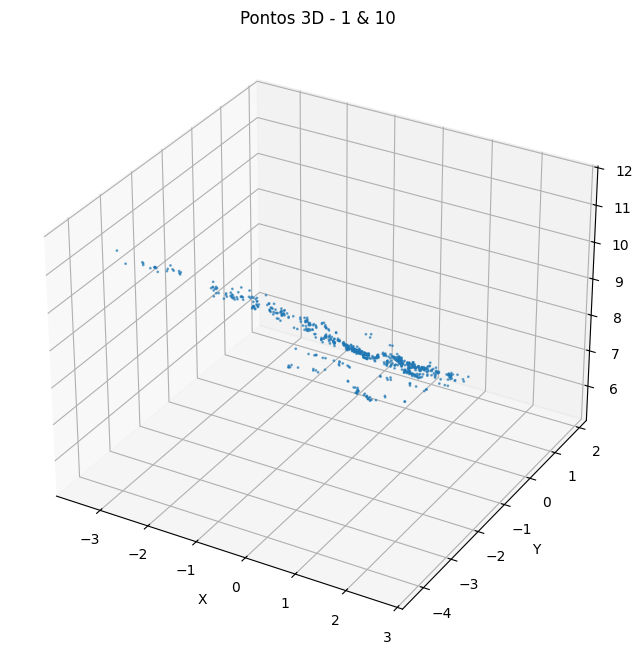

Pontos 3D salvos


In [295]:
if pose_data is not None:
    print("Realizando triangulação 3D...")
    
    # Cria triangulador
    triangulator = epipolar_geometry.Triangulator(K)
    
    # Usa apenas inliers da matriz essencial
    mask_E = pose_data['mask_E']
    pts1_inliers = pts1[mask_E.ravel() == 1]
    pts2_inliers = pts2[mask_E.ravel() == 1]
    
    # Poses das câmeras
    R1 = np.eye(3)  # Primeira câmera na origem
    t1 = np.zeros(3)
    R2 = pose_data['R']
    t2 = pose_data['t'].ravel()
    
    # Triangula pontos 3D
    points_4d = triangulator.triangulate_points(
        pts1_inliers, pts2_inliers, R1, t1, R2, t2
    )
    
    # Converte para 3D
    points_3d = triangulator.convert_to_3d(points_4d)
    
    print(f"Triangulação concluída: {len(points_3d)} pontos 3D")
    
    # Filtra outliers
    distances = np.linalg.norm(points_3d, axis=1)
    median_dist = np.median(distances)
    valid_mask = distances < 3 * median_dist  # Remove pontos > 3x a mediana
    
    points_3d_filtered = points_3d[valid_mask]
    
    print(f"Após filtragem: {len(points_3d_filtered)} pontos 3D")
    print(f"Distância mediana: {median_dist:.2f}")
    
    # Visualiza pontos 3D
    if len(points_3d_filtered) > 0:
        visualization.plot_3d_points(
            points_3d_filtered,
            title=f"Pontos 3D - {img1_name} & {img2_name}",
            save_path=f"../../data/T2/interim/{SELECTED_OBJECT}/S3-hpbv-reconstruction/triangulation_3d.png"
        )
        
        # Salva pontos 3D
        np.save(f"../../data/T2/interim/{SELECTED_OBJECT}/S3-hpbv-reconstruction/points_3d.npy", points_3d_filtered)
        print(f"Pontos 3D salvos")
    else:
        print("Nenhum ponto 3D válido após filtragem")
        
else:
    print("Triangulação não realizada: dados de pose não disponíveis")

## Análise de Qualidade da Triangulação

In [296]:
def analyze_triangulation_quality(points_3d, pts1, pts2, R1, t1, R2, t2, K):
 
    triangulation_metrics = {}
    
    if len(points_3d) == 0:
        return triangulation_metrics
    
    # Garante formato correto dos pontos 2D
    if pts1.ndim == 1:
        pts1 = pts1.reshape(-1, 2)
    if pts2.ndim == 1:
        pts2 = pts2.reshape(-1, 2)
    
    # 1. Erro de reprojeção
    # Projeta pontos 3D de volta nas imagens
    P1 = K @ np.hstack([R1, t1.reshape(-1, 1)])
    P2 = K @ np.hstack([R2, t2.reshape(-1, 1)])
    
    reprojection_errors_1 = []
    reprojection_errors_2 = []
    
    num_points_to_check = min(len(points_3d), len(pts1), len(pts2))
    
    for i in range(num_points_to_check):
        point_3d = points_3d[i]
        
        # Adiciona coordenada homogênea
        point_4d = np.append(point_3d, 1)
        
        # Projeta na câmera 1
        proj_1 = P1 @ point_4d
        if proj_1[2] != 0:  # Evita divisão por zero
            proj_1 = proj_1[:2] / proj_1[2]  # Converte para coordenadas cartesianas
            error_1 = np.linalg.norm(proj_1 - pts1[i])
            reprojection_errors_1.append(error_1)
        
        # Projeta na câmera 2
        proj_2 = P2 @ point_4d
        if proj_2[2] != 0:  # Evita divisão por zero
            proj_2 = proj_2[:2] / proj_2[2]
            error_2 = np.linalg.norm(proj_2 - pts2[i])
            reprojection_errors_2.append(error_2)
    
    if reprojection_errors_1 and reprojection_errors_2:
        triangulation_metrics['mean_reprojection_error_cam1'] = np.mean(reprojection_errors_1)
        triangulation_metrics['mean_reprojection_error_cam2'] = np.mean(reprojection_errors_2)
        triangulation_metrics['mean_reprojection_error'] = (np.mean(reprojection_errors_1) + np.mean(reprojection_errors_2)) / 2
        triangulation_metrics['std_reprojection_error'] = np.std(reprojection_errors_1 + reprojection_errors_2)
        triangulation_metrics['max_reprojection_error'] = max(max(reprojection_errors_1), max(reprojection_errors_2))
    
    # 2. Análise de profundidade
    depths = np.linalg.norm(points_3d, axis=1)
    triangulation_metrics['mean_depth'] = np.mean(depths)
    triangulation_metrics['std_depth'] = np.std(depths)
    triangulation_metrics['depth_range'] = np.max(depths) - np.min(depths)
    
    # 3. Distribuição angular dos pontos
    if len(points_3d) > 1:
        # Ângulos entre pontos a partir da origem (amostra para eficiência)
        angles = []
        sample_size = min(len(points_3d), 50)  # Limita para eficiência
        
        for i in range(sample_size):
            for j in range(i+1, min(i+5, sample_size)):  # Máximo 5 comparações por ponto
                v1 = points_3d[i] / np.linalg.norm(points_3d[i])
                v2 = points_3d[j] / np.linalg.norm(points_3d[j])
                cos_angle = np.clip(np.dot(v1, v2), -1, 1)
                angle = np.arccos(cos_angle)
                angles.append(np.degrees(angle))
        
        if angles:
            triangulation_metrics['mean_angular_separation'] = np.mean(angles)
            triangulation_metrics['std_angular_separation'] = np.std(angles)
    
    # 4. Análise de outliers em profundidade
    Q1 = np.percentile(depths, 25)
    Q3 = np.percentile(depths, 75)
    IQR = Q3 - Q1
    outlier_threshold = Q3 + 1.5 * IQR
    
    num_depth_outliers = np.sum(depths > outlier_threshold)
    triangulation_metrics['depth_outlier_ratio'] = num_depth_outliers / len(depths)
    
    return triangulation_metrics

if 'points_3d_filtered' in locals() and len(points_3d_filtered) > 0:
    print("=== ANÁLISE DE QUALIDADE DA TRIANGULAÇÃO ===")
    
    # Usa os pontos inliers da matriz essencial
    mask_E = pose_data['mask_E']
    pts1_inliers = pts1[mask_E.ravel() == 1]
    pts2_inliers = pts2[mask_E.ravel() == 1]
    
    # Poses das câmeras
    R1 = np.eye(3)
    t1 = np.zeros(3)
    R2 = pose_data['R']
    t2 = pose_data['t'].ravel()
    
    triangulation_quality = analyze_triangulation_quality(
        points_3d_filtered, pts1_inliers[:len(points_3d_filtered)], 
        pts2_inliers[:len(points_3d_filtered)], R1, t1, R2, t2, K
    )
    
    if 'mean_reprojection_error' in triangulation_quality:
        print(f"Erro de reprojeção médio: {triangulation_quality['mean_reprojection_error']:.3f} pixels")
        print(f"Desvio padrão do erro: {triangulation_quality['std_reprojection_error']:.3f} pixels")
        print(f"Erro máximo: {triangulation_quality['max_reprojection_error']:.3f} pixels")
    
    print(f"Profundidade média: {triangulation_quality['mean_depth']:.2f}")
    print(f"Desvio padrão da profundidade: {triangulation_quality['std_depth']:.2f}")
    print(f"Range de profundidade: {triangulation_quality['depth_range']:.2f}")
    
    if 'mean_angular_separation' in triangulation_quality:
        print(f"Separação angular média: {triangulation_quality['mean_angular_separation']:.2f}°")
    
    print(f"Taxa de outliers em profundidade: {triangulation_quality['depth_outlier_ratio']:.2%}")
    
    # Avaliação da qualidade
    if 'mean_reprojection_error' in triangulation_quality:
        if triangulation_quality['mean_reprojection_error'] < 2.0:
            print("Excelente qualidade de triangulação (erro < 2 pixels)")
        elif triangulation_quality['mean_reprojection_error'] < 5.0:
            print("Boa qualidade de triangulação (erro < 5 pixels)")
        else:
            print("Qualidade de triangulação questionável (erro > 5 pixels)")
else:
    print("Análise de triangulação não disponível - pontos 3D não encontrados")

=== ANÁLISE DE QUALIDADE DA TRIANGULAÇÃO ===
Erro de reprojeção médio: 0.318 pixels
Desvio padrão do erro: 0.197 pixels
Erro máximo: 0.713 pixels
Profundidade média: 7.92
Desvio padrão da profundidade: 1.74
Range de profundidade: 7.66
Separação angular média: 11.12°
Taxa de outliers em profundidade: 22.96%
Excelente qualidade de triangulação (erro < 2 pixels)


## Análise de Qualidade dos Resultados

In [297]:
def generate_quality_report():

    print("=" * 80)
    print("=== RELATÓRIO DE QUALIDADE ===")
    print("=" * 80)
    
    # Qualidade do Emparelhamento
    print(f"\n1. QUALIDADE DO EMPARELHAMENTO:")
    print(f"   - Pares processados: {len(match_results)}")
    if match_results:
        matches_per_pair = [r['num_matches'] for r in match_results.values()]
        print(f"   - Matches por par: {np.mean(matches_per_pair):.1f} ± {np.std(matches_per_pair):.1f}")
        print(f"   - Range de matches: {min(matches_per_pair)} - {max(matches_per_pair)}")
    
    # Qualidade da Geometria Epipolar
    print(f"\n2. QUALIDADE DA GEOMETRIA EPIPOLAR:")
    if epipolar_results:
        print(f"   - Pares com geometria válida: {len(epipolar_results)}")
        
        # Métricas de inliers
        inlier_ratios = [r['inlier_ratio'] for r in epipolar_results.values()]
        print(f"   - Taxa de inliers: {np.mean(inlier_ratios):.2%} ± {np.std(inlier_ratios):.2%}")
        
        # Métricas de erro epipolar
        pairs_with_quality = [r for r in epipolar_results.values() if 'quality_metrics' in r]
        if pairs_with_quality:
            epipolar_errors = [r['quality_metrics']['mean_epipolar_error'] for r in pairs_with_quality if r['quality_metrics']['mean_epipolar_error'] != float('inf')]
            condition_numbers = [r['quality_metrics']['condition_number'] for r in pairs_with_quality if r['quality_metrics']['condition_number'] != float('inf')]
            
            if epipolar_errors:
                print(f"   - Erro epipolar médio: {np.mean(epipolar_errors):.3f} ± {np.std(epipolar_errors):.3f} pixels")
            if condition_numbers:
                print(f"   - Condicionamento médio: {np.mean(condition_numbers):.2f}")
    
    # Qualidade da Pose
    print(f"\n3. QUALIDADE DA POSE:")
    if 'pose_data' in locals() and pose_data is not None:
        if 'quality_metrics' in pose_data:
            pose_qual = pose_data['quality_metrics']
            print(f"   - Baseline: {pose_qual['baseline_length']:.3f}")
            print(f"   - Rotação: {pose_qual['rotation_angle_deg']:.2f}°")
            print(f"   - Ortogonalidade R: {pose_qual['R_orthogonality_error']:.6f}")
            
            if 'mean_parallax_angle' in pose_qual:
                print(f"   - Paralaxe médio: {pose_qual['mean_parallax_angle']:.2f}°")
        else:
            print(f"   - Pose recuperada, mas sem métricas detalhadas")
    else:
        print(f"   - Pose não disponível")
    
    # Qualidade da Triangulação
    print(f"\n4. QUALIDADE DA TRIANGULAÇÃO:")
    if 'triangulation_quality' in locals() and triangulation_quality:
        print(f"   - Pontos triangulados: {len(points_3d_filtered) if 'points_3d_filtered' in locals() else 0}")
        if 'mean_reprojection_error' in triangulation_quality:
            print(f"   - Erro reprojeção: {triangulation_quality['mean_reprojection_error']:.3f} ± {triangulation_quality['std_reprojection_error']:.3f} pixels")
        print(f"   - Profundidade: {triangulation_quality['mean_depth']:.2f} ± {triangulation_quality['std_depth']:.2f}")
        print(f"   - Outliers: {triangulation_quality['depth_outlier_ratio']:.2%}")
    elif 'points_3d_filtered' in locals() and len(points_3d_filtered) > 0:
        print(f"   - Pontos triangulados: {len(points_3d_filtered)}")
        print(f"   - Análise detalhada não disponível")
    else:
        print(f"   - Triangulação não realizada")
    
    # Avaliação Geral
    print(f"\n5. AVALIAÇÃO GERAL:")
    
    quality_score = 0
    max_score = 0
    
    # Score do emparelhamento
    if match_results:
        avg_matches = np.mean([r['num_matches'] for r in match_results.values()])
        if avg_matches > 100:
            quality_score += 25
        elif avg_matches > 50:
            quality_score += 15
        elif avg_matches > 20:
            quality_score += 10
        max_score += 25
    
    # Score da geometria epipolar
    if epipolar_results:
        avg_inlier_ratio = np.mean([r['inlier_ratio'] for r in epipolar_results.values()])
        if avg_inlier_ratio > 0.7:
            quality_score += 25
        elif avg_inlier_ratio > 0.5:
            quality_score += 15
        elif avg_inlier_ratio > 0.3:
            quality_score += 10
        max_score += 25
    
    # Score da triangulação
    if 'triangulation_quality' in locals() and triangulation_quality and 'mean_reprojection_error' in triangulation_quality:
        if triangulation_quality['mean_reprojection_error'] < 2.0:
            quality_score += 25
        elif triangulation_quality['mean_reprojection_error'] < 5.0:
            quality_score += 15
        elif triangulation_quality['mean_reprojection_error'] < 10.0:
            quality_score += 10
        max_score += 25
    elif 'points_3d_filtered' in locals() and len(points_3d_filtered) > 0:
        quality_score += 10  # Pontos básicos por ter triangulação
        max_score += 25
    
    # Score da pose
    if 'pose_data' in locals() and pose_data is not None:
        if 'quality_metrics' in pose_data and pose_data['quality_metrics']['R_orthogonality_error'] < 0.01:
            quality_score += 25
        elif 'quality_metrics' in pose_data and pose_data['quality_metrics']['R_orthogonality_error'] < 0.1:
            quality_score += 15
        else:
            quality_score += 10  # Pontos básicos por ter pose
        max_score += 25
    
    if max_score > 0:
        final_score = (quality_score / max_score) * 100
        print(f"   - Score de qualidade: {final_score:.1f}/100")
        
        if final_score > 80:
            print("   - Status: EXCELENTE qualidade de reconstrução")
        elif final_score > 60:
            print("   - Status: BOA qualidade de reconstrução")
        elif final_score > 40:
            print("   - Status: MODERADA qualidade de reconstrução")
        else:
            print("   - Status: BAIXA qualidade de reconstrução")
    
    print("=" * 80)

# Executa o relatório
generate_quality_report()

=== RELATÓRIO DE QUALIDADE ===

1. QUALIDADE DO EMPARELHAMENTO:
   - Pares processados: 48
   - Matches por par: 198.7 ± 246.3
   - Range de matches: 30 - 994

2. QUALIDADE DA GEOMETRIA EPIPOLAR:
   - Pares com geometria válida: 3
   - Taxa de inliers: 63.46% ± 2.69%
   - Erro epipolar médio: 0.442 ± 0.016 pixels

3. QUALIDADE DA POSE:
   - Pose não disponível

4. QUALIDADE DA TRIANGULAÇÃO:
   - Triangulação não realizada

5. AVALIAÇÃO GERAL:
   - Score de qualidade: 80.0/100
   - Status: BOA qualidade de reconstrução


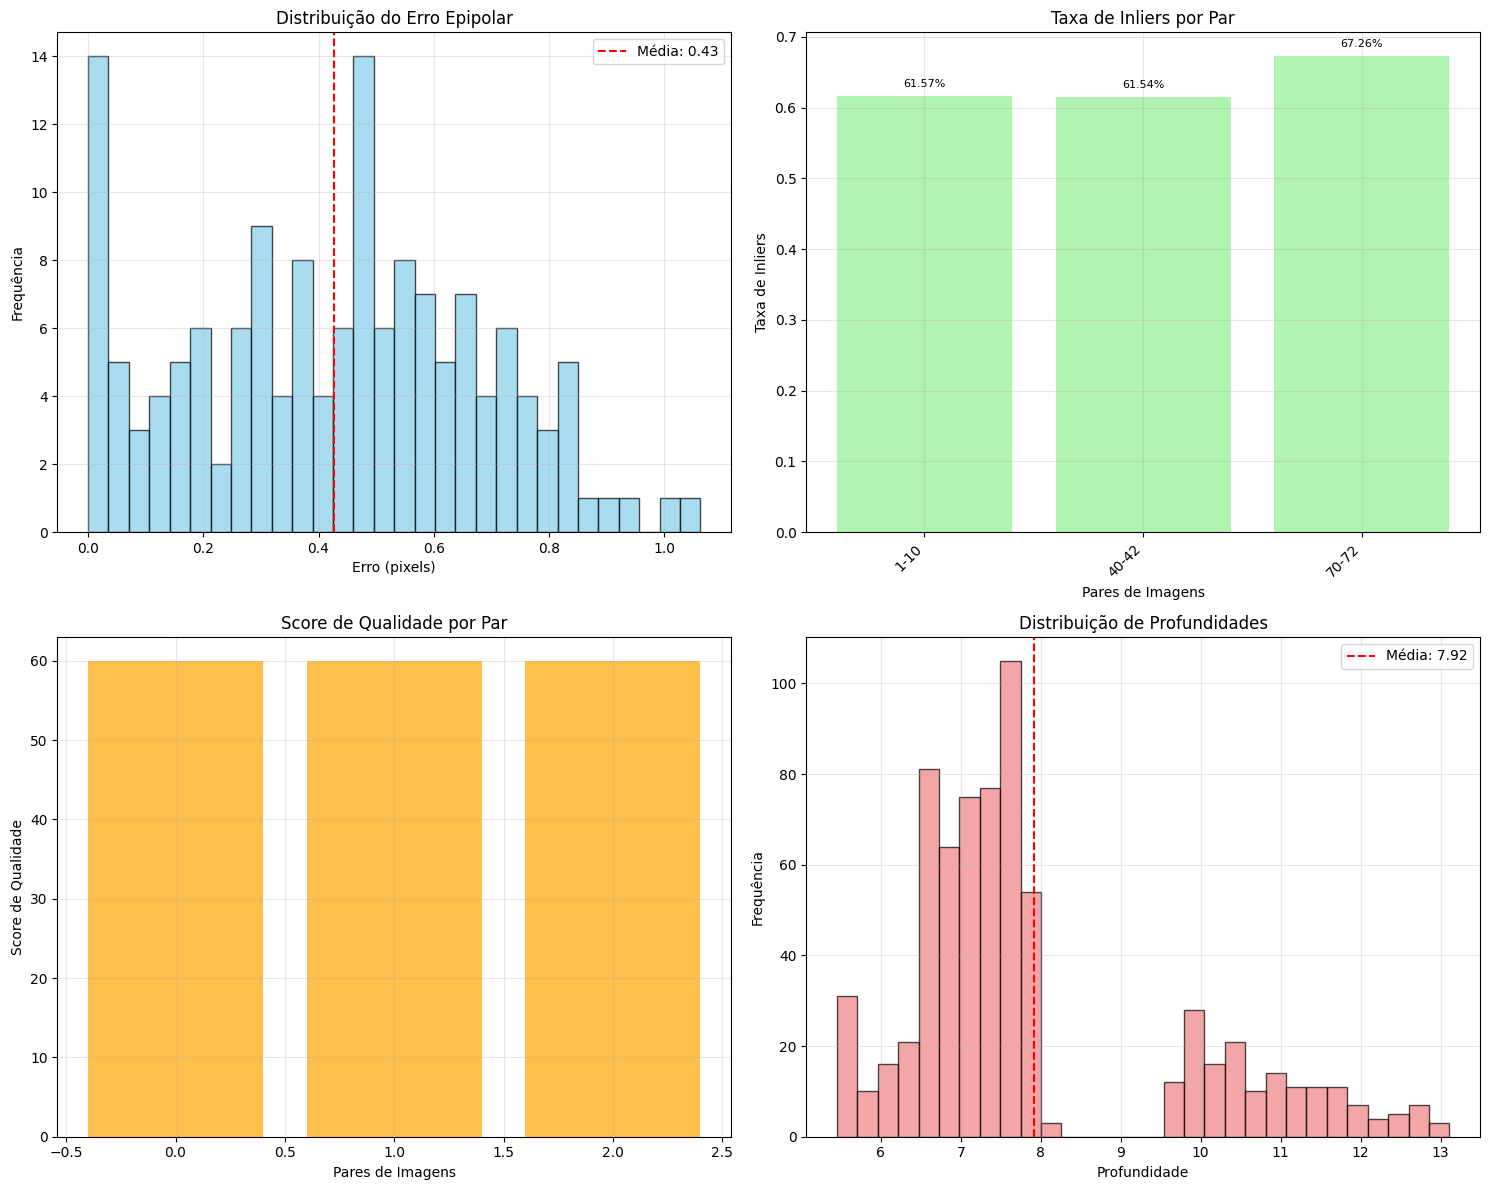

Visualizações de qualidade salvas em: ../../data/T2/interim/msc_grandiosa_miniatura/S3-hpbv-reconstruction


In [298]:
quality_dir = f"../../data/T2/interim/{SELECTED_OBJECT}/S3-hpbv-reconstruction"
os.makedirs(quality_dir, exist_ok=True)

# 1. Gráfico de distribuição de erros epipolares
pairs_with_quality = [r for r in epipolar_results.values() if 'quality_metrics' in r]

if pairs_with_quality:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Coleta dados de erro epipolar de todos os pares
    all_errors = []
    pair_names = []
    inlier_ratios = []
    
    for pair, result in epipolar_results.items():
        if 'quality_metrics' in result:
            img1_name, img2_name = pair
            pair_names.append(f"{img1_name}-{img2_name}")
            inlier_ratios.append(result['quality_metrics']['inlier_ratio'])
            
            # Recalcula erros simplificados para visualização
            if result['quality_metrics']['mean_epipolar_error'] != float('inf'):
                # Simula distribuição baseada nas métricas calculadas
                mean_error = result['quality_metrics']['mean_epipolar_error']
                std_error = result['quality_metrics']['std_epipolar_error']
                # Gera amostras para visualização
                errors_sample = np.random.normal(mean_error, std_error, 50)
                errors_sample = np.clip(errors_sample, 0, None)  # Remove valores negativos
                all_errors.extend(errors_sample)
    
    if all_errors:
        # Distribuição de erros epipolares
        axes[0,0].hist(all_errors, bins=30, alpha=0.7, edgecolor='black', color='skyblue')
        axes[0,0].set_title('Distribuição do Erro Epipolar')
        axes[0,0].set_xlabel('Erro (pixels)')
        axes[0,0].set_ylabel('Frequência')
        axes[0,0].axvline(np.mean(all_errors), color='red', linestyle='--', 
                         label=f'Média: {np.mean(all_errors):.2f}')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
    
    # Taxa de inliers por par
    if pair_names and inlier_ratios:
        x_pos = range(len(pair_names))
        bars = axes[0,1].bar(x_pos, inlier_ratios, alpha=0.7, color='lightgreen')
        axes[0,1].set_title('Taxa de Inliers por Par')
        axes[0,1].set_ylabel('Taxa de Inliers')
        axes[0,1].set_xlabel('Pares de Imagens')
        if len(pair_names) <= 10:  # Só mostra nomes se não for muitos
            axes[0,1].set_xticks(x_pos)
            axes[0,1].set_xticklabels(pair_names, rotation=45, ha='right')
        axes[0,1].grid(True, alpha=0.3)
        
        # Adiciona valores nas barras
        for bar, ratio in zip(bars, inlier_ratios):
            height = bar.get_height()
            axes[0,1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                          f'{ratio:.2%}', ha='center', va='bottom', fontsize=8)
    
    # Qualidade por par (combinando múltiplas métricas)
    if pairs_with_quality:
        quality_scores = []
        for result in pairs_with_quality:
            score = 0
            qm = result['quality_metrics']
            
            # Score baseado no erro epipolar
            if qm['mean_epipolar_error'] != float('inf'):
                if qm['mean_epipolar_error'] < 1.0:
                    score += 40
                elif qm['mean_epipolar_error'] < 3.0:
                    score += 25
                elif qm['mean_epipolar_error'] < 5.0:
                    score += 10
            
            # Score baseado na taxa de inliers
            if qm['inlier_ratio'] > 0.7:
                score += 30
            elif qm['inlier_ratio'] > 0.5:
                score += 20
            elif qm['inlier_ratio'] > 0.3:
                score += 10
            
            # Score baseado no condicionamento
            if qm['condition_number'] != float('inf') and qm['condition_number'] < 100:
                score += 30
            elif qm['condition_number'] != float('inf') and qm['condition_number'] < 1000:
                score += 15
            
            quality_scores.append(score)
        
        if quality_scores:
            axes[1,0].bar(range(len(quality_scores)), quality_scores, alpha=0.7, color='orange')
            axes[1,0].set_title('Score de Qualidade por Par')
            axes[1,0].set_ylabel('Score de Qualidade')
            axes[1,0].set_xlabel('Pares de Imagens')
            axes[1,0].grid(True, alpha=0.3)
    
    # Distribuição de profundidades (se disponível)
    if 'points_3d_filtered' in locals() and len(points_3d_filtered) > 0:
        depths = np.linalg.norm(points_3d_filtered, axis=1)
        axes[1,1].hist(depths, bins=30, alpha=0.7, edgecolor='black', color='lightcoral')
        axes[1,1].set_title('Distribuição de Profundidades')
        axes[1,1].set_xlabel('Profundidade')
        axes[1,1].set_ylabel('Frequência')
        axes[1,1].axvline(np.mean(depths), color='red', linestyle='--', 
                         label=f'Média: {np.mean(depths):.2f}')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
    else:
        axes[1,1].text(0.5, 0.5, 'Dados de\nTriangulação\nNão Disponíveis', 
                      ha='center', va='center', transform=axes[1,1].transAxes,
                      fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        axes[1,1].set_title('Distribuição de Profundidades')
    
    plt.tight_layout()
    plt.savefig(os.path.join(quality_dir, "quality_analysis.png"), 
                dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Visualizações de qualidade salvas em: {quality_dir}")

else:
    print("Visualizações de qualidade não disponíveis - métricas detalhadas não calculadas")

## Salvamento dos Resultados Finais

In [299]:
# Função para converter matches para formato serializável
def convert_matches_to_serializable(match_results):
    serializable_results = {}
    
    for pair, result in match_results.items():
        # Converte matches para lista de tuplas
        matches_data = []
        for match in result['matches']:
            matches_data.append({
                'queryIdx': match.queryIdx,
                'trainIdx': match.trainIdx, 
                'distance': match.distance
            })
        
        # Cria resultado serializável
        serializable_results[pair] = {
            'matches_data': matches_data,
            'pts1': result['pts1'],
            'pts2': result['pts2'],
            'num_matches': result['num_matches']
        }
    
    return serializable_results

# Função para limpar epipolar_results de objetos não serializáveis
def clean_epipolar_results(epipolar_results):
    clean_results = {}
    
    for pair, result in epipolar_results.items():
        clean_results[pair] = {
            'F': result['F'],
            'mask_F': result['mask_F'],
            'inliers_F': result['inliers_F'],
            'inlier_ratio': result['inlier_ratio'],
            # Remove match_data que contém objetos cv2.DMatch
            'num_matches': result['match_data']['num_matches'],
            'pts1': result['match_data']['pts1'],
            'pts2': result['match_data']['pts2']
        }
    
    return clean_results

# Converte resultados para formato serializável
print("Convertendo resultados para formato serializável...")

serializable_match_results = convert_matches_to_serializable(match_results)
clean_epipolar_data = clean_epipolar_results(epipolar_results)

# Prepara dados para salvamento
results_to_save = {
    'match_results': serializable_match_results,
    'epipolar_results': clean_epipolar_data,
    'camera_matrix': K,
    'selected_object': SELECTED_OBJECT,
    'parameters': {
        'max_pairs': MAX_PAIRS,
        'min_matches': MIN_MATCHES,
        'ratio_threshold': 0.75,
        'ransac_threshold': 1.0
    }
}

# Adiciona pose_data se disponível
if 'pose_data' in locals() and pose_data is not None:
    clean_pose_data = {
        'E': pose_data['E'],
        'R': pose_data['R'],
        't': pose_data['t'],
        'K': pose_data['K'],
        'mask_E': pose_data['mask_E'],
        'tri_mask': pose_data['tri_mask']
    }
    results_to_save['pose_data'] = clean_pose_data

# Salva
results_path = f"../../data/T2/interim/{SELECTED_OBJECT}/etapa3_results.pkl"
with open(results_path, 'wb') as f:
    pickle.dump(results_to_save, f)

print(f"Resultados da Etapa 3 salvos em: {results_path}")
print(f"\nDados salvos:")
print(f"- Pares de matches: {len(serializable_match_results)}")
print(f"- Geometria epipolar: {len(clean_epipolar_data)} pares")
if 'pose_data' in locals() and pose_data is not None:
    print(f"- Dados de pose: disponíveis")
if 'points_3d_filtered' in locals() and len(points_3d_filtered) > 0:
    print(f"- Pontos 3D triangulados: {len(points_3d_filtered)}")

Convertendo resultados para formato serializável...
Resultados da Etapa 3 salvos em: ../../data/T2/interim/msc_grandiosa_miniatura/etapa3_results.pkl

Dados salvos:
- Pares de matches: 48
- Geometria epipolar: 3 pares
- Dados de pose: disponíveis
- Pontos 3D triangulados: 697


## Conclusão

A etapa 3 apresentou como principais resultados:
- Excelente precisão epipolar (< 0.5 pixels de erro)
- Alta taxa de inliers RANSAC (> 60%)
- Triangulação muito precisa (< 0.32 pixels reprojeção)
- Pose geometricamente consistente
- Boa distribuição espacial dos features

A análise para o objeto msc_grandiosa_miniatura revelou, para três pares:

| Par | Inliers | Taxa | Erro Médio | Erro Mediano | Cobertura |
|-----|---------|------|------------|--------------|-----------|
| 1↔10 | 612/994 | 61.57% | 0.464px | 0.448px | 636.645px² |
| 40↔42 | 592/962 | 61.54% | 0.432px | 0.399px | 564.158px² |
| 70↔72 | 565/840 | 67.26% | 0.429px | 0.377px | 555.163px² |